# Julia version of bonding models for PES !!

### Basic Optimization tests

In [30]:
using Optim, LsqFit # opt libs
using LinearAlgebra # self explanatory
using ReverseDiff # autodiff
using Plots, LaTeXStrings # plots
using DelimitedFiles, MLUtils, BenchmarkTools # utils

In [116]:
# examples of "closures", a technique to fix args!
f(x::Vector, a, b) = (x[1] - a)^2 + (x[2] - b)^2

using Optim
g(x::Vector) = f(x, 3, 4)
optimize(g, [0.,0.])

 * Status: success

 * Candidate solution
    Final objective value:     1.226133e-10

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    50
    f(x) calls:    100


In [117]:
# another closure example in Julia, anonymous function:
optimize(x -> f(x,3,4), [0.,0.]) 

 * Status: success

 * Candidate solution
    Final objective value:     1.226133e-10

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    50
    f(x) calls:    100


In [2]:
# functional form:
function f_ratpot_2(Θ, R, M)
    #=
    ansatz 1 for diatomic potential
    params:
        - Θ := training parameters, vector ()
        - R := distances, vector
    =#
    # unroll coefficients
    a = Θ[1:M]
    b = Θ[M+1:2*M]
    c = Θ[2*M+1:3*M+4]
    d = Θ[3*M+5:4*M+7]
    
    # b_i ≥ 0 for i > 1:
    t = b[2:M]
    bool = t .< 0.
    t[bool] = -t[bool]
    b[2:M] = t
    
    # d_i ≥ 0 for i > 0:
    bool = d .< 0.
    d[bool] = -d[bool]    
    
    # evaluate P:
    P = c[end-1]
    P = P .* ((R .- a[1]).^2 .+ (b[1] .* R))
    for i=2:M
        P .*= (R .- a[i]).^2 .+ (b[i]*R)
    end

    
    # eval Q:
    Q = (R .+ d[end]).*R
    for i=1:M+2
        Q .*= (R .- c[i]).^2 .+ d[i].*R
    end
    
    # eval potential:
    V = c[end] .+ (P ./ Q)
    return V
end

f_RMSE(X, Y) = √(sum((X .- Y) .^ 2)/length(X))

function f_least_squares(f_eval, Y, f_args...)
    Y_pred = f_eval(f_args...)
    res = sum((Y .- Y_pred).^2)
    return res
end

f_least_squares (generic function with 1 method)

In [212]:
M = 2
Θ = collect(LinRange(-1., -2., 21))
Θ = Θ[1:4*M+7] # 4M+7 params
println(Θ, size(Θ))
R = collect(LinRange(0., 5., 6)) .+ 1
println(R)
f_ratpot_2(Θ, R, M)

[-1.0, -1.05, -1.1, -1.15, -1.2000000000000002, -1.25, -1.2999999999999998, -1.35, -1.4, -1.4500000000000002, -1.5, -1.55, -1.6, -1.65, -1.7](15,)
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
[-1.1, 1.15]
[1.5, 1.55, 1.6, 1.65, 1.7]


6-element Vector{Float64}:
 -1.4538848497222299
 -1.4504032610414908
 -1.450089540167252
 -1.4500280979713995
 -1.450010836561844
 -1.4500048065726545

#### Optimize ratpot 2 !!

In [3]:
# prepare data:
H_data = readdlm("data/h2/h2_ground_w.txt")
R = H_data[:, 1]; V = H_data[:, 2]
Xs, Ys = shuffleobs((R, V))
train_data, test_data = splitobs((Xs, Ys); at=0.8)
R_train = copy(train_data[1]); V_train = copy(train_data[2]);
R_test = copy(test_data[1]); V_test = copy(test_data[2]);

# tuning parameters:
M = 20
ub = 10; lb = 0
θ = rand(4*M+7) .* (ub-lb) .+ lb # random between [a, b] = [-1, 1]
#println(f_ratpot_2(θ, R_train, M))
f_least_squares(f_ratpot_2, V_train, θ, R_train, M)

4404.864370899371

In [4]:
# optimize:

res = optimize(θ -> f_least_squares(f_ratpot_2, V_train, θ, R_train, M),
                θ, BFGS(),
                Optim.Options(iterations = 2000, show_trace=true); 
                autodiff = :forward
                )

Iter     Function value   Gradient norm 
     0     4.404864e+03     3.062211e+03
 * time: 0.01399993896484375
     1     2.793404e+03     2.440113e+03
 * time: 0.7990000247955322
     2     1.630070e+01     2.054986e+00
 * time: 0.812000036239624
     3     1.629872e+01     8.659113e-03
 * time: 0.8209998607635498
     4     1.623607e+01     5.600086e+00
 * time: 0.8889999389648438
     5     1.623432e+01     1.959398e+00
 * time: 0.9119999408721924
     6     1.621126e+01     8.370857e-01
 * time: 0.9229998588562012
     7     1.620387e+01     1.160661e+00
 * time: 0.9440000057220459
     8     1.619207e+01     1.135099e+00
 * time: 0.9639999866485596
     9     1.618045e+01     3.816732e-01
 * time: 0.9779999256134033
    10     1.613029e+01     1.295419e+01
 * time: 0.9939999580383301
    11     1.584807e+01     5.226360e+01
 * time: 1.0390000343322754
    12     1.584544e+01     5.503163e+01
 * time: 1.0829999446868896
    13     1.573687e+01     5.396900e+01
 * time: 1.0910000801

   120     1.033421e-04     3.278408e-02
 * time: 2.259000062942505
   121     9.759661e-05     2.962836e-02
 * time: 2.2690000534057617
   122     9.418553e-05     1.530917e-02
 * time: 2.2820000648498535
   123     9.204677e-05     3.411398e-03
 * time: 2.2960000038146973
   124     9.096486e-05     2.953289e-03
 * time: 2.302000045776367
   125     9.013070e-05     5.460474e-03
 * time: 2.309000015258789
   126     8.963581e-05     5.160004e-03
 * time: 2.315999984741211
   127     8.943762e-05     1.304418e-03
 * time: 2.3269999027252197
   128     8.911740e-05     3.887631e-03
 * time: 2.3329999446868896
   129     8.708551e-05     2.123379e-02
 * time: 2.3459999561309814
   130     8.373967e-05     2.494811e-02
 * time: 2.3559999465942383
   131     7.825803e-05     3.904916e-02
 * time: 2.365000009536743
   132     7.451538e-05     4.135836e-02
 * time: 2.372999906539917
   133     7.281997e-05     1.607791e-02
 * time: 2.381999969482422
   134     7.124462e-05     2.137468e-02


   240     8.393406e-06     7.189699e-04
 * time: 3.4129998683929443
   241     8.383559e-06     2.693552e-04
 * time: 3.421999931335449
   242     8.373837e-06     8.535068e-04
 * time: 3.430000066757202
   243     8.366244e-06     1.274197e-03
 * time: 3.437999963760376
   244     8.340059e-06     5.983128e-04
 * time: 3.4489998817443848
   245     8.306630e-06     1.754274e-03
 * time: 3.4619998931884766
   246     8.281918e-06     3.587015e-03
 * time: 3.4739999771118164
   247     8.254672e-06     3.657691e-03
 * time: 3.4789998531341553
   248     8.233224e-06     3.390320e-03
 * time: 3.484999895095825
   249     8.171514e-06     2.351461e-03
 * time: 3.493000030517578
   250     8.055552e-06     2.608718e-03
 * time: 3.500999927520752
   251     7.972921e-06     1.852941e-03
 * time: 3.51200008392334
   252     7.846761e-06     6.602139e-04
 * time: 3.5199999809265137
   253     7.793081e-06     3.921411e-03
 * time: 3.5320000648498535
   254     7.688746e-06     2.702694e-03
 

   361     3.878768e-06     1.247204e-03
 * time: 4.6519999504089355
   362     3.813689e-06     2.949838e-03
 * time: 4.662999868392944
   363     3.804321e-06     3.232468e-03
 * time: 4.675999879837036
   364     3.781788e-06     1.996771e-03
 * time: 4.683000087738037
   365     3.769767e-06     2.583854e-03
 * time: 4.691999912261963
   366     3.755177e-06     8.771728e-04
 * time: 4.694999933242798
   367     3.745423e-06     3.559733e-04
 * time: 4.70199990272522
   368     3.730694e-06     1.595028e-03
 * time: 4.710000038146973
   369     3.710211e-06     9.228669e-04
 * time: 4.7170000076293945
   370     3.698558e-06     1.005507e-03
 * time: 4.726999998092651
   371     3.686994e-06     7.179547e-04
 * time: 4.734999895095825
   372     3.675850e-06     6.846601e-04
 * time: 4.747999906539917
   373     3.663203e-06     2.265246e-03
 * time: 4.760999917984009
   374     3.652998e-06     1.846160e-03
 * time: 4.767999887466431
   375     3.630089e-06     1.022246e-03
 * tim

   482     1.444510e-06     1.550290e-03
 * time: 5.703999996185303
   483     1.439209e-06     1.001724e-03
 * time: 5.710999965667725
   484     1.434615e-06     7.841825e-04
 * time: 5.7209999561309814
   485     1.428665e-06     8.014224e-04
 * time: 5.728999853134155
   486     1.426292e-06     2.566635e-04
 * time: 5.740000009536743
   487     1.425648e-06     3.599164e-04
 * time: 5.746999979019165
   488     1.425435e-06     1.448209e-04
 * time: 5.756999969482422
   489     1.424800e-06     1.482361e-04
 * time: 5.766999959945679
   490     1.423052e-06     6.162086e-04
 * time: 5.772000074386597
   491     1.417523e-06     6.600706e-04
 * time: 5.7809998989105225
   492     1.391232e-06     1.721418e-03
 * time: 5.792999982833862
   493     1.382971e-06     1.405119e-03
 * time: 5.796000003814697
   494     1.367367e-06     5.009336e-04
 * time: 5.802000045776367
   495     1.351493e-06     9.023372e-04
 * time: 5.812000036239624
   496     1.329956e-06     1.659382e-03
 * ti

   603     5.230351e-07     2.180976e-04
 * time: 6.7790000438690186
   604     5.194674e-07     5.332281e-04
 * time: 6.787999868392944
   605     5.177285e-07     3.145452e-04
 * time: 6.792999982833862
   606     5.140212e-07     1.467133e-03
 * time: 6.802999973297119
   607     5.064226e-07     1.078091e-03
 * time: 6.813999891281128
   608     5.028601e-07     4.669600e-04
 * time: 6.822000026702881
   609     4.995383e-07     6.327936e-04
 * time: 6.832000017166138
   610     4.950884e-07     1.084229e-03
 * time: 6.838000059127808
   611     4.877506e-07     4.638379e-04
 * time: 6.852999925613403
   612     4.820202e-07     1.577954e-03
 * time: 6.865000009536743
   613     4.763736e-07     1.114823e-03
 * time: 6.868000030517578
   614     4.696426e-07     1.000442e-03
 * time: 6.879999876022339
   615     4.648855e-07     1.571015e-03
 * time: 6.888000011444092
   616     4.563710e-07     9.151059e-04
 * time: 6.898999929428101
   617     4.501155e-07     7.712616e-04
 * tim

   724     3.276896e-07     3.672702e-04
 * time: 7.810999870300293
   725     3.264683e-07     2.295563e-04
 * time: 7.822000026702881
   726     3.244194e-07     3.550013e-04
 * time: 7.828999996185303
   727     3.207097e-07     4.952477e-04
 * time: 7.833999872207642
   728     3.194145e-07     3.524213e-04
 * time: 7.8450000286102295
   729     3.184722e-07     2.074653e-04
 * time: 7.851999998092651
   730     3.167007e-07     4.038364e-04
 * time: 7.861000061035156
   731     3.138534e-07     1.306744e-03
 * time: 7.865999937057495
   732     3.128773e-07     1.013350e-03
 * time: 7.872999906539917
   733     3.115215e-07     7.421391e-04
 * time: 7.875999927520752
   734     3.098416e-07     2.666677e-04
 * time: 7.881999969482422
   735     3.078727e-07     9.924567e-05
 * time: 7.892999887466431
   736     3.068037e-07     6.600145e-04
 * time: 7.8999998569488525
   737     3.032262e-07     6.008822e-04
 * time: 7.9079999923706055
   738     3.026607e-07     4.459523e-04
 * t

   845     1.068204e-07     1.481564e-04
 * time: 8.77999997138977
   846     1.052824e-07     3.226445e-04
 * time: 8.787999868392944
   847     1.040113e-07     6.918366e-04
 * time: 8.796000003814697
   848     1.030955e-07     5.033904e-04
 * time: 8.80299997329712
   849     1.023325e-07     2.918951e-04
 * time: 8.813999891281128
   850     1.011389e-07     3.660722e-04
 * time: 8.823999881744385
   851     1.003084e-07     7.278001e-04
 * time: 8.830999851226807
   852     9.843690e-08     4.742589e-04
 * time: 8.839999914169312
   853     9.729487e-08     7.370441e-04
 * time: 8.84500002861023
   854     9.635561e-08     1.781880e-04
 * time: 8.852999925613403
   855     9.472193e-08     3.219134e-04
 * time: 8.855999946594238
   856     9.350603e-08     5.493772e-04
 * time: 8.865999937057495
   857     9.262630e-08     2.092731e-04
 * time: 8.86899995803833
   858     9.207617e-08     1.015014e-04
 * time: 8.875
   859     9.143303e-08     7.424939e-05
 * time: 8.891999959945

   967     5.980341e-08     4.625336e-05
 * time: 9.812000036239624
   968     5.979742e-08     5.307512e-05
 * time: 9.819000005722046
   969     5.978627e-08     2.144631e-05
 * time: 9.82200002670288
   970     5.977975e-08     1.369479e-05
 * time: 9.835000038146973
   971     5.977294e-08     7.846334e-05
 * time: 9.84500002861023
   972     5.976623e-08     5.166527e-05
 * time: 9.852999925613403
   973     5.974896e-08     4.035025e-05
 * time: 9.861999988555908
   974     5.969326e-08     4.662935e-05
 * time: 9.875
   975     5.966859e-08     1.427793e-05
 * time: 9.881999969482422
   976     5.962224e-08     1.058353e-04
 * time: 9.888999938964844
   977     5.959438e-08     2.210089e-05
 * time: 9.895999908447266
   978     5.957473e-08     7.055790e-05
 * time: 9.901999950408936
   979     5.956044e-08     2.488070e-05
 * time: 9.91599988937378
   980     5.953832e-08     9.251981e-05
 * time: 9.925999879837036
   981     5.951874e-08     9.934774e-06
 * time: 9.93099999427

  1087     4.756087e-08     6.474250e-05
 * time: 10.805999994277954
  1088     4.743789e-08     2.333911e-04
 * time: 10.815999984741211
  1089     4.731590e-08     2.940624e-05
 * time: 10.825999975204468
  1090     4.729529e-08     2.442931e-05
 * time: 10.835000038146973
  1091     4.724593e-08     3.999421e-05
 * time: 10.838000059127808
  1092     4.722690e-08     6.294446e-05
 * time: 10.843999862670898
  1093     4.720729e-08     7.506919e-05
 * time: 10.8510000705719
  1094     4.716809e-08     6.519507e-05
 * time: 10.86299991607666
  1095     4.713606e-08     1.529979e-04
 * time: 10.869999885559082
  1096     4.709894e-08     1.293225e-04
 * time: 10.879999876022339
  1097     4.705578e-08     5.458176e-05
 * time: 10.885999917984009
  1098     4.702445e-08     4.740765e-05
 * time: 10.8989999294281
  1099     4.701900e-08     4.434588e-05
 * time: 10.905999898910522
  1100     4.700906e-08     2.574828e-05
 * time: 10.912999868392944
  1101     4.699633e-08     2.205454e-0

  1207     4.440715e-08     4.485481e-05
 * time: 11.787999868392944
  1208     4.436518e-08     6.774354e-05
 * time: 11.793999910354614
  1209     4.434169e-08     5.892789e-05
 * time: 11.800999879837036
  1210     4.425785e-08     5.713789e-05
 * time: 11.805999994277954
  1211     4.425113e-08     6.585071e-05
 * time: 11.812000036239624
  1212     4.419693e-08     5.861399e-05
 * time: 11.815000057220459
  1213     4.417542e-08     5.478452e-05
 * time: 11.819999933242798
  1214     4.415682e-08     3.706124e-05
 * time: 11.829999923706055
  1215     4.413737e-08     2.028990e-05
 * time: 11.839999914169312
  1216     4.412300e-08     5.987942e-05
 * time: 11.846999883651733
  1217     4.411855e-08     7.982329e-06
 * time: 11.851999998092651
  1218     4.411391e-08     1.403698e-05
 * time: 11.865000009536743
  1219     4.411188e-08     1.683865e-05
 * time: 11.875999927520752
  1220     4.411048e-08     9.016342e-07
 * time: 11.88100004196167
  1221     4.410889e-08     7.05187

  1327     4.296217e-08     6.030100e-05
 * time: 12.740000009536743
  1328     4.293436e-08     1.200356e-05
 * time: 12.74399995803833
  1329     4.292280e-08     2.376679e-05
 * time: 12.75
  1330     4.290789e-08     9.002477e-05
 * time: 12.753000020980835
  1331     4.288814e-08     5.951090e-05
 * time: 12.760999917984009
  1332     4.286011e-08     3.813623e-05
 * time: 12.769000053405762
  1333     4.281880e-08     5.089041e-05
 * time: 12.773000001907349
  1334     4.277113e-08     1.535859e-04
 * time: 12.785000085830688
  1335     4.274878e-08     1.492063e-04
 * time: 12.79200005531311
  1336     4.272468e-08     1.250013e-04
 * time: 12.799999952316284
  1337     4.268409e-08     7.993891e-05
 * time: 12.80299997329712
  1338     4.262903e-08     7.506033e-05
 * time: 12.806999921798706
  1339     4.260529e-08     6.118528e-05
 * time: 12.816999912261963
  1340     4.256542e-08     5.514534e-05
 * time: 12.82800006866455
  1341     4.251834e-08     1.220450e-04
 * time: 1

  1447     3.846263e-08     1.231425e-04
 * time: 13.60699987411499
  1448     3.835958e-08     1.051289e-04
 * time: 13.618000030517578
  1449     3.827940e-08     9.254415e-05
 * time: 13.625
  1450     3.822816e-08     1.166662e-04
 * time: 13.647000074386597
  1451     3.820117e-08     1.430619e-04
 * time: 13.652999877929688
  1452     3.813625e-08     1.939225e-04
 * time: 13.655999898910522
  1453     3.806546e-08     6.950205e-05
 * time: 13.664000034332275
  1454     3.802257e-08     1.262297e-04
 * time: 13.670000076293945
  1455     3.799640e-08     2.388509e-05
 * time: 13.680000066757202
  1456     3.796817e-08     4.867569e-05
 * time: 13.690000057220459
  1457     3.795471e-08     4.269820e-05
 * time: 13.694000005722046
  1458     3.793524e-08     4.753536e-05
 * time: 13.703999996185303
  1459     3.790252e-08     9.465130e-05
 * time: 13.71399998664856
  1460     3.785734e-08     1.223020e-04
 * time: 13.723000049591064
  1461     3.775414e-08     1.483558e-04
 * time

  1567     2.784578e-08     2.654445e-05
 * time: 14.477999925613403
  1568     2.782327e-08     7.257762e-05
 * time: 14.490999937057495
  1569     2.777407e-08     7.983030e-05
 * time: 14.49399995803833
  1570     2.776381e-08     7.072581e-05
 * time: 14.497999906539917
  1571     2.772000e-08     1.046459e-04
 * time: 14.520999908447266
  1572     2.767471e-08     1.187270e-04
 * time: 14.526999950408936
  1573     2.763844e-08     5.002302e-05
 * time: 14.52999997138977
  1574     2.760715e-08     8.637362e-05
 * time: 14.53600001335144
  1575     2.755464e-08     2.045461e-04
 * time: 14.54099988937378
  1576     2.740473e-08     2.875749e-04
 * time: 14.549000024795532
  1577     2.730739e-08     3.299978e-04
 * time: 14.552000045776367
  1578     2.713868e-08     1.438670e-04
 * time: 14.558000087738037
  1579     2.687864e-08     1.127424e-04
 * time: 14.562999963760376
  1580     2.659307e-08     2.083656e-04
 * time: 14.57800006866455
  1581     2.649832e-08     2.443378e-0

  1687     1.981331e-08     8.469641e-05
 * time: 15.389999866485596
  1688     1.980466e-08     1.405067e-05
 * time: 15.398000001907349
  1689     1.979199e-08     5.296152e-05
 * time: 15.40499997138977
  1690     1.978145e-08     6.558709e-05
 * time: 15.41599988937378
  1691     1.976345e-08     6.376730e-05
 * time: 15.420000076293945
  1692     1.975420e-08     3.834053e-05
 * time: 15.430000066757202
  1693     1.973670e-08     7.596640e-05
 * time: 15.437000036239624
  1694     1.971636e-08     7.929444e-06
 * time: 15.44700002670288
  1695     1.970755e-08     2.523706e-05
 * time: 15.450000047683716
  1696     1.969432e-08     6.375197e-05
 * time: 15.455999851226807
  1697     1.968753e-08     2.293858e-05
 * time: 15.460000038146973
  1698     1.968309e-08     6.615063e-05
 * time: 15.466000080108643
  1699     1.967459e-08     6.693854e-05
 * time: 15.470999956130981
  1700     1.966110e-08     2.352684e-05
 * time: 15.480000019073486
  1701     1.965461e-08     5.441345e

  1807     1.471043e-08     1.024274e-04
 * time: 16.277999877929688
  1808     1.465740e-08     1.799933e-04
 * time: 16.287999868392944
  1809     1.462866e-08     5.048260e-05
 * time: 16.2979998588562
  1810     1.459440e-08     1.190599e-04
 * time: 16.305000066757202
  1811     1.458071e-08     1.277944e-04
 * time: 16.308000087738037
  1812     1.455399e-08     1.497116e-04
 * time: 16.312000036239624
  1813     1.451666e-08     1.368081e-04
 * time: 16.32200002670288
  1814     1.448424e-08     1.456920e-04
 * time: 16.33299994468689
  1815     1.446093e-08     5.958031e-05
 * time: 16.335999965667725
  1816     1.443532e-08     1.817367e-05
 * time: 16.33899998664856
  1817     1.441787e-08     1.828646e-05
 * time: 16.346999883651733
  1818     1.439882e-08     5.534342e-05
 * time: 16.35599994659424
  1819     1.436990e-08     1.373292e-04
 * time: 16.36299991607666
  1820     1.434943e-08     1.606989e-04
 * time: 16.369999885559082
  1821     1.433930e-08     2.305833e-04


  1927     1.199080e-08     9.394632e-05
 * time: 17.149999856948853
  1928     1.197570e-08     1.713417e-05
 * time: 17.152999877929688
  1929     1.195674e-08     5.532750e-05
 * time: 17.16000008583069
  1930     1.195024e-08     7.004180e-05
 * time: 17.162999868392944
  1931     1.193227e-08     9.310323e-05
 * time: 17.168999910354614
  1932     1.190855e-08     9.979035e-05
 * time: 17.18400001525879
  1933     1.188438e-08     1.145837e-04
 * time: 17.194000005722046
  1934     1.185812e-08     2.248771e-05
 * time: 17.204999923706055
  1935     1.184291e-08     3.051145e-05
 * time: 17.2189998626709
  1936     1.181906e-08     1.032138e-04
 * time: 17.22499990463257
  1937     1.180969e-08     4.028805e-05
 * time: 17.227999925613403
  1938     1.179983e-08     1.040133e-04
 * time: 17.240000009536743
  1939     1.178199e-08     9.041857e-05
 * time: 17.250999927520752
  1940     1.173953e-08     2.705260e-05
 * time: 17.256999969482422
  1941     1.173241e-08     2.045151e-0

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     9.611939e-09

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 5.21e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.83e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.00e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.12e-03 ≰ 0.0e+00
    |g(x)|                 = 7.12e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   18  (vs limit Inf)
    Iterations:    2000
    f(x) calls:    5173
    ∇f(x) calls:   5173


In [5]:
# check RMSE:
V_pred = f_ratpot_2(res.minimizer, R_train, M)
println(f_RMSE(V_train, V_pred))
V_pred = f_ratpot_2(res.minimizer, R_test, M)
println(f_RMSE(V_test, V_pred))
for i=1:length(V_test)
    println(V_pred[i]," ",V_test[i])
end

4.234704519894572e-6
2.9276919358380464e-6
-0.0008473614097407878 -0.0008457269999999628
-0.07954291804404812 -0.07954594900000012
-0.1519622732506834 -0.15195909900000015
-0.11653569803675493 -0.1165328080000001
-0.03391427554983345 -0.03391220100000014
-0.005351304696011028 -0.005348754000000122
-0.16747835744279463 -0.16748270900000017
-0.17098887938290577 -0.17099233300000005
-5.478405504333317e-5 -5.306299999996433e-5
-0.031062824242911735 -0.031061373000000003
-0.010857211378577925 -0.010857708000000077
-0.026627807954423488 -0.026627746000000174
-0.15506383270077323 -0.15506615300000015
-0.07577424840002328 -0.07577727099999998
-8.232465193436234e-6 -6.208000000063052e-6
-0.0006030500384439641 -0.0006003549999999969
-0.0010596603561299767 -0.001059486000000165
-0.01959761557770706 -0.019599871000000046
-9.81964487805631e-5 -9.699600000012687e-5
-0.021836953193801134 -0.02183858500000002
-0.15661983418865094 -0.15662260100000003
-0.03696914403296936 -0.036966681
-0.16865910473891

### 8.1 Bonding features

In [75]:
function t_R_fun(R, R_up, R_low, e)
    R2 = R.^2
    return ((R2 .- R_low^2)./(R_up^2 .- R2)).^e
end

#function s_bond_strength

t_R_fun (generic function with 1 method)

In [76]:
R = [2.5, 3.1, 5, 1.1]
@benchmark t_R_fun(R, 6, 1, 2)

BenchmarkTools.Trial: 10000 samples with 982 evaluations.
 Range (min … max):  59.369 ns …  1.314 μs  ┊ GC (min … max): 0.00% … 92.58%
 Time  (median):     61.507 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   67.030 ns ± 56.162 ns  ┊ GC (mean ± σ):  5.19% ±  5.87%

  ▄██▄▅▄▃▂▁▁                                                  ▂
  ███████████▇▇▇▆▆▆▅▄▅▆▄▄▄▆▄▃▅▄▁▃▁▄▁▁▃▄▃▃▁▁▁▁▁▃▁▁▃▁▁▃▅▆▇▇██▇▇ █
  59.4 ns      Histogram: log(frequency) by time       119 ns <

 Memory estimate: 192 bytes, allocs estimate: 2.

## New bonding features (bump functions)

In [27]:
#=
these primitive features replaces the b array, z is equivalent to b_1 (d=1), while f is d ≥ 2
=#
# test the z function derivation:
A = [1 1 1 -1; 1 -1 -1 1; 0 -1 -5 3; 0 0 20 -6]
b = [1 0 0 0]'
r = A\b
println(r)

[0.5; 0.9375; 0.18750000000000006; 0.6250000000000001;;]


### $z(t)$ coordinate function

In [28]:
# z(t) coordinate function:
function z_coord(t)
    z = zeros(Float64, size(t)) # default values, t ≥ 1
    # indexes:
    low_idx = t .≤ -1.
    high_idx = t .≥ 1. # this subarray is 0
    mid_idx = (.!low_idx) .& (.!high_idx)
    # fill subarrays:
    z[low_idx] .= 1. # fill lower bound subarray
    # fill intermediate subarray:
    t2 = t.^2
    t_mid = t[mid_idx]
    t2_mid = t2[mid_idx]
    z[mid_idx] .= @. 0.5 - t_mid*(0.9375 + t2_mid*(0.18750000000000006*t2_mid - 0.6250000000000001))
    return z
end

∂z_coord(t) = @. -0.9375 - 5*0.18750000000000006*(t^4) + 3*0.6250000000000001*(t^2)
∂∂z_coord(t) = @. -20*0.18750000000000006*(t^3) + 6*0.6250000000000001*t

t0 = [-1., 1.]
println(z_coord(t0))
println(∂z_coord(t0))
println(∂∂z_coord(t0))
# autodiff but very ineffficient way, just for checking): 
#println(map(x -> ReverseDiff.jacobian(z_coord, [x]), t0))
#println(map(x -> ReverseDiff.hessian(z_coord, [x]), t0))

# for plot:
t = collect(LinRange(-1.5, 1.5, Int(1e4)))
z = z_coord(t);
∂z = ∂z_coord(t);
∂∂z = ∂∂z_coord(t);

[1.0, 0.0]
[2.220446049250313e-16, 2.220446049250313e-16]
[0.0, 0.0]


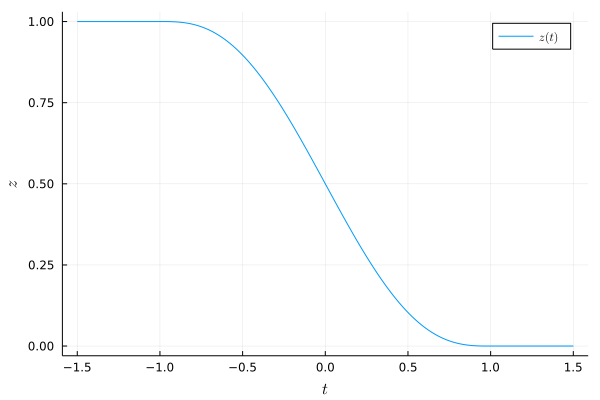

In [31]:
# plot z, z', z'':
plot(t, z, label = L"z(t)")
xlabel!(L"t"); ylabel!(L"z")

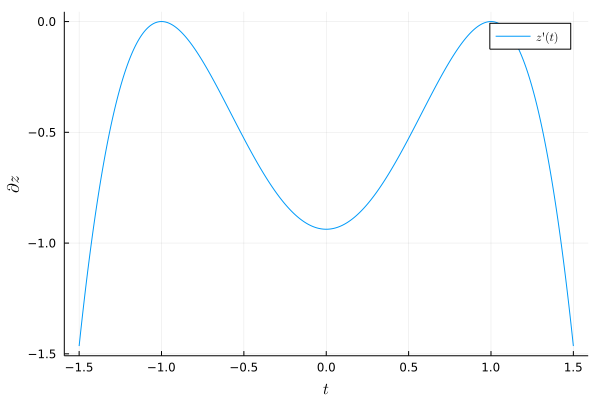

In [32]:
plot(t, ∂z, label = L"$z'(t)$")
xlabel!(L"$t$"); ylabel!(L"$\partial z$")

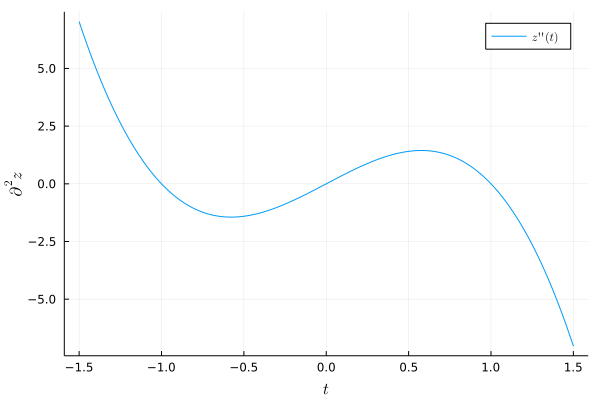

In [33]:
plot(t, ∂∂z, label = L"$z''(t)$")
xlabel!(L"$t$"); ylabel!(L"$\partial^2 z$")